# Quadrotor Control in MuJoCo: PID vs MLP vs PPO

This project compares three control strategies for stabilizing a quadrotor
in MuJoCo simulation:

- **PID controller**
- **Supervised MLP policy**
- **Reinforcement Learning (PPO)**

The goal is to evaluate stability, drift, thrust efficiency, and robustness
under stress conditions.


## Environment Setup

This notebook uses MuJoCo and Stable-Baselines3.  
All dependencies are installed automatically in Colab.

**SideNote**: MuJoCo requires Linux-based execution (e.g. Colab).


In [ ]:
# Cell 1: Install Dependencies
!pip install -q mujoco gymnasium stable-baselines3 torch pandas numpy matplotlib

# Clone the MuJoCo Menagerie (contains the official Crazyflie drone model)
!git clone https://github.com/google-deepmind/mujoco_menagerie.git

fatal: destination path 'mujoco_menagerie' already exists and is not an empty directory.


## Simulation Environment

We define a **single, consistent quadrotor environment** shared across
all controllers to ensure fair comparison.

### Key Properties
- Continuous action space: motor thrusts ∈ [0, 1]
- Observation includes position, velocity, orientation, and angular velocity
- Target task: hover at a fixed height


In [ ]:
# Cell 2: environment

import numpy as np
import mujoco
import gymnasium as gym
from gymnasium import spaces

class CrazyflieEnv(gym.Env):
    """
    Consistent env:
      - action is always 4 motors in [0, 1]
      - action maps linearly to each motor's actuator_ctrlrange high
      - NO actuator_gear rewrites
      - frame_skip supported
      - reset can optionally start on ground (z=0) sometimes (for takeoff training)
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        model_path: str,
        target_height: float = 1.0,
        episode_length: int = 1200,
        frame_skip: int = 10,
        max_tilt_rad: float = np.deg2rad(60),
        crash_height: float = 0.05,
        p_takeoff: float = 0.3,  # probability of starting on ground
        start_z_air: tuple = (0.1, 0.5),
        seed: int | None = None,
    ):
        super().__init__()
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.data = mujoco.MjData(self.model)

        self.target_height = float(target_height)
        self.episode_length = int(episode_length)
        self.frame_skip = int(frame_skip)
        self.max_tilt = float(max_tilt_rad)
        self.crash_height = float(crash_height)
        self.p_takeoff = float(p_takeoff)
        self.start_z_air = start_z_air

        self.sim_t = 0
        self.drone_body_id = self.model.body("cf2").id

        # Determine per-motor ctrl scaling from model ctrlrange (do not override it blindly)
        ctrl = np.array(self.model.actuator_ctrlrange, dtype=np.float32)  # shape (n_act, 2)
        if ctrl.shape[0] < 4:
            raise ValueError(f"Expected at least 4 actuators, got {ctrl.shape[0]}")
        self.ctrl_low = ctrl[:4, 0].copy()
        self.ctrl_high = ctrl[:4, 1].copy()

        # If ctrlrange is degenerate, fall back to [0, 1]
        if not np.all(np.isfinite(self.ctrl_high)) or np.any(self.ctrl_high <= self.ctrl_low):
            self.ctrl_low = np.zeros(4, dtype=np.float32)
            self.ctrl_high = np.ones(4, dtype=np.float32)

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(17,), dtype=np.float32)

        self.prev_action = np.zeros(4, dtype=np.float32)

        if seed is not None:
            np.random.seed(seed)

    @property
    def control_dt(self) -> float:
        return float(self.model.opt.timestep) * self.frame_skip

    def _quat_to_rpy(self, quat):
        w, x, y, z = quat
        t0 = +2.0*(w*x + y*z); t1 = +1.0 - 2.0*(x*x + y*y); roll = np.arctan2(t0, t1)
        t2 = +2.0*(w*y - z*x); t2 = np.clip(t2, -1.0, 1.0); pitch = np.arcsin(t2)
        t3 = +2.0*(w*z + x*y); t4 = +1.0 - 2.0*(y*y + z*z); yaw = np.arctan2(t3, t4)
        return roll, pitch, yaw

    def _get_obs(self) -> np.ndarray:
        # sensor slices assume  model's sensor order; kept consistent with original
        acc = self.data.sensordata[0:3]
        gyro = self.data.sensordata[3:6]
        mag = self.data.sensordata[6:9]

        quat = self.data.qpos[3:7]
        roll, pitch, yaw = self._quat_to_rpy(quat)

        lin_vel = self.data.qvel[0:3]
        height = self.data.xpos[self.drone_body_id][2]

        obs = np.concatenate(
            [acc, gyro, mag, [roll, pitch, yaw], lin_vel, [height], [self.target_height]],
            dtype=np.float32
        )
        return obs.astype(np.float32)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)

        mujoco.mj_resetData(self.model, self.data)
        self.sim_t = 0
        self.prev_action[:] = 0.0

        # Start on ground sometimes to teach TAKEOFF
        if np.random.rand() < self.p_takeoff:
            self.data.qpos[2] = 0.0
        else:
            self.data.qpos[2] = np.random.uniform(self.start_z_air[0], self.start_z_air[1])

        mujoco.mj_forward(self.model, self.data)
        return self._get_obs(), {}

    def step(self, action):
        action = np.clip(action, 0.0, 1.0).astype(np.float32)

        # scale [0,1] -> [ctrl_low, ctrl_high]
        ctrl = self.ctrl_low + action * (self.ctrl_high - self.ctrl_low)

        for _ in range(self.frame_skip):
            self.data.ctrl[:4] = ctrl
            mujoco.mj_step(self.model, self.data)

        self.sim_t += 1
        obs = self._get_obs()

        roll, pitch, yaw = obs[9:12]
        gyro = obs[3:6]
        height = obs[15]
        h_err = self.target_height - height

        # Reward shaping: DO NOT punish thrust magnitude (that traps RL at 0)
        r_height = np.exp(-2.0 * abs(h_err))
        r_tilt = np.exp(-3.0 * (roll*roll + pitch*pitch))
        r_rates = np.exp(-0.15 * float(np.sum(gyro*gyro)))

        jerk = action - self.prev_action
        p_jerk = 0.05 * float(np.mean(jerk*jerk))

        reward = 0.2 + 2.0*r_height + 1.0*r_tilt + 0.5*r_rates - p_jerk

        done = False
        crash = False
        tilt_fail = False

        if height < self.crash_height:
            done = True
            crash = True
            reward -= 5.0

        if (abs(roll) > self.max_tilt) or (abs(pitch) > self.max_tilt):
            done = True
            tilt_fail = True
            reward -= 3.0

        if self.sim_t >= self.episode_length:
            done = True

        self.prev_action = action.copy()

        info = {
            "height": float(height),
            "h_err": float(h_err),
            "roll": float(roll),
            "pitch": float(pitch),
            "yaw": float(yaw),
            "crash": crash,
            "tilt_fail": tilt_fail,
            "p_jerk": float(p_jerk),
        }
        return obs, float(reward), done, False, info


## Baseline Controller: PID

A classical PID controller is implemented as a baseline.
It controls vertical position and stabilizes orientation.

This controller is also used to:
- Generate training data for the MLP
- Provide a performance baseline


In [ ]:
# Cell 3: PID + data collection

import pandas as pd

def estimate_hover_action(env: CrazyflieEnv, z_target=1.0, steps=1500) -> float:
    """
    Rough hover estimator: tries constant equal action on all motors and converges using a slow PI on height.
    Returns a normalized action in [0,1] (same as env.action_space).
    """
    obs, _ = env.reset(seed=123)
    env.data.qpos[2] = float(z_target)
    mujoco.mj_forward(env.model, env.data)

    a = 0.5
    integ = 0.0
    vals = []

    for t in range(steps):
        height = env.data.xpos[env.drone_body_id][2]
        err = z_target - height
        integ += err * 0.001
        a = np.clip(a + 0.02*err + integ, 0.0, 1.0)

        env.step(np.array([a, a, a, a], dtype=np.float32))

        if t > steps // 2:
            vals.append(a)

    return float(np.mean(vals)) if vals else float(a)

class PIDController:
    def __init__(self, target_height: float, dt: float, hover_action: float):
        self.target_height = float(target_height)
        self.dt = float(dt)
        self.hover = float(hover_action)

        self.kp_z, self.ki_z, self.kd_z = 2.5, 0.8, 1.0
        self.kp_att, self.kd_att = 3.0, 0.25
        self.kp_yaw, self.kd_yaw = 0.6, 0.05

        self.reset()

    def reset(self):
        self.i_z = 0.0
        self.prev_z = 0.0
        self.prev_r = 0.0
        self.prev_p = 0.0
        self.prev_y = 0.0

    def compute_action(self, obs: np.ndarray) -> np.ndarray:
        roll, pitch, yaw = obs[9:12]
        z = obs[15]
        z_err = self.target_height - z

        self.i_z = float(np.clip(self.i_z + z_err * self.dt, -0.5, 0.5))
        dz = (z_err - self.prev_z) / self.dt
        self.prev_z = z_err

        base = self.hover + (self.kp_z*z_err + self.ki_z*self.i_z + self.kd_z*dz)
        base = float(np.clip(base, 0.0, 1.0))

        r_err = -roll; dr = (r_err - self.prev_r)/self.dt; self.prev_r = r_err
        p_err = -pitch; dp = (p_err - self.prev_p)/self.dt; self.prev_p = p_err
        y_err = -yaw;   dy = (y_err - self.prev_y)/self.dt; self.prev_y = y_err

        r_cmd = self.kp_att*r_err + self.kd_att*dr
        p_cmd = self.kp_att*p_err + self.kd_att*dp
        y_cmd = self.kp_yaw*y_err + self.kd_yaw*dy

        m1 = base + p_cmd - r_cmd - y_cmd
        m2 = base - p_cmd - r_cmd + y_cmd
        m3 = base - p_cmd + r_cmd - y_cmd
        m4 = base + p_cmd + r_cmd + y_cmd

        return np.clip([m1, m2, m3, m4], 0.0, 1.0).astype(np.float32)

def collect_pid_dataset(model_path: str, target_h=1.0, episodes=30, steps=800):
    env = CrazyflieEnv(model_path, target_height=target_h, episode_length=steps, frame_skip=10)
    hover = estimate_hover_action(env, z_target=target_h)
    pid = PIDController(target_h, dt=env.control_dt, hover_action=hover)

    rows = []
    for ep in range(episodes):
        obs, _ = env.reset(seed=1000 + ep)
        pid.reset()
        for t in range(steps):
            act = pid.compute_action(obs)
            nxt, rew, done, _, info = env.step(act)

            row = {f"obs_{i}": float(obs[i]) for i in range(17)}
            row.update({f"act_{i}": float(act[i]) for i in range(4)})
            rows.append(row)

            obs = nxt
            if done:
                break

    df = pd.DataFrame(rows)
    df.to_csv("drone_data.csv", index=False)
    print(f"Saved drone_data.csv with shape {df.shape} | hover_action≈{hover:.3f}")


## Supervised Policy Learning (MLP)

We train a Multilayer Perceptron (MLP) to imitate the PID controller.

- Input: environment observations
- Output: motor thrust actions
- Loss: Mean Squared Error (MSE)

This evaluates how well imitation learning can replace classical control.


In [ ]:
# Cell 4: Train MLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

class DroneNet(nn.Module):
    def __init__(self, in_dim=17, out_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

def train_mlp(path_csv="drone_data.csv"):
    import pandas as pd
    df = pd.read_csv(path_csv)

    X = df[[c for c in df.columns if c.startswith("obs_")]].values.astype(np.float32)
    y = df[[c for c in df.columns if c.startswith("act_")]].values.astype(np.float32)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train).astype(np.float32)
    Xva = scaler.transform(X_val).astype(np.float32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = DroneNet().to(device)

    opt = optim.Adam(net.parameters(), lr=3e-4)
    loss_fn = nn.MSELoss()

    Xtr_t = torch.tensor(Xtr, device=device)
    ytr_t = torch.tensor(y_train, device=device)
    Xva_t = torch.tensor(Xva, device=device)
    yva_t = torch.tensor(y_val, device=device)

    best = float("inf")
    bad = 0
    patience = 15
    batch_size = 512

    for ep in range(1, 201):
        net.train()
        idx = torch.randperm(Xtr_t.size(0), device=device)
        total = 0.0

        for s in range(0, Xtr_t.size(0), batch_size):
            b = idx[s:s+batch_size]
            pred = net(Xtr_t[b])
            loss = loss_fn(pred, ytr_t[b])
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += float(loss.item())

        net.eval()
        with torch.no_grad():
            val = float(loss_fn(net(Xva_t), yva_t).item())

        if ep % 10 == 0 or ep == 1:
            print(f"epoch {ep:4d} | train {total:.5f} | val {val:.5f}")

        if val < best - 1e-6:
            best = val
            bad = 0
            torch.save(net.state_dict(), "mlp_policy.pt")
            joblib.dump(scaler, "mlp_obs_scaler.joblib")
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    print(f"Saved mlp_policy.pt + mlp_obs_scaler.joblib | best val {best:.6f}")

def mlp_policy_fn(mlp: DroneNet, scaler: StandardScaler, obs_raw_1d: np.ndarray, device) -> np.ndarray:
    x = scaler.transform(obs_raw_1d.reshape(1, -1)).astype(np.float32)
    with torch.no_grad():
        a = mlp(torch.tensor(x, device=device)).cpu().numpy()[0]
    return a.astype(np.float32)


## Reinforcement Learning Controller (PPO)

We train a PPO agent using Stable-Baselines3.

### Reward Design
- Penalizes deviation from target height
- Penalizes excessive angular velocity
- Encourages stable hover

Training uses the same environment to ensure fair comparison.


In [ ]:
# Cell 5: Train PPO (RL)

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

def train_ppo(model_path: str, target_h=1.0):
    def make_env_fn():
        def _init():
            env = CrazyflieEnv(
                model_path,
                target_height=target_h,
                episode_length=1200,
                frame_skip=10,
                p_takeoff=0.3,       # <-- teaches takeoff
                crash_height=0.05
            )
            return Monitor(env)
        return _init

    n_envs = 8
    vec_env = make_vec_env(make_env_fn(), n_envs=n_envs, vec_env_cls=SubprocVecEnv)
    vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

    eval_env = make_vec_env(make_env_fn(), n_envs=1)
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=False, clip_obs=10.0)
    eval_env.training = False
    eval_env.norm_reward = False

    checkpoint_cb = CheckpointCallback(save_freq=200_000, save_path="./ppo_checkpoints", name_prefix="ppo_cf2")
    eval_cb = EvalCallback(eval_env, best_model_save_path="./ppo_best", log_path="./ppo_eval",
                           eval_freq=50_000, deterministic=True, render=False)

    ppo = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=256,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.0,
        clip_range=0.2,
        vf_coef=0.5,
        max_grad_norm=0.5,
        policy_kwargs=dict(net_arch=[256, 256]),
    )

    ppo.learn(total_timesteps=2_000_000, callback=[checkpoint_cb, eval_cb])
    ppo.save("ppo_cf2_final")
    vec_env.save("vecnormalize_stats.pkl")
    print("Saved: ppo_cf2_final.zip + vecnormalize_stats.pkl")


## Evaluation Methodology

All controllers are evaluated on:
- Trajectory drift
- Vertical stability
- Control smoothness
- Thrust efficiency

Each controller runs for the same number of steps
from identical initial conditions.


In [ ]:
# Cell 6: Evaluation (PPO vs PID vs MLP)

import matplotlib.pyplot as plt
import joblib
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

def make_eval_vecenv(model_path: str, target_h=1.0):
    v = DummyVecEnv([lambda: CrazyflieEnv(model_path, target_height=target_h, episode_length=1200, frame_skip=10, p_takeoff=0.3)])
    v = VecNormalize.load("vecnormalize_stats.pkl", v)
    v.training = False
    v.norm_reward = False
    return v

def rollout_all(model_path: str, target_h=1.0, steps=800):
    # VecNormalize env for PPO (returns normalized obs to the policy)
    venv = make_eval_vecenv(model_path, target_h)

    # raw env for PID/MLP
    raw_env = CrazyflieEnv(model_path, target_height=target_h, episode_length=1200, frame_skip=10, p_takeoff=0.3)

    # Load PPO
    ppo = PPO.load("ppo_cf2_final", env=venv)

    # Load MLP
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mlp = DroneNet().to(device)
    mlp.load_state_dict(torch.load("mlp_policy.pt", map_location=device))
    mlp.eval()
    scaler = joblib.load("mlp_obs_scaler.joblib")

    # PID (hover computed on raw env)
    hover = estimate_hover_action(raw_env, z_target=target_h)
    pid = PIDController(target_h, dt=raw_env.control_dt, hover_action=hover)

    def run(policy_name: str):
        H, R, P, A = [], [], [], []

        if policy_name == "PPO":
            obs = venv.reset()  # normalized
            for _ in range(steps):
                action, _ = ppo.predict(obs, deterministic=True)
                obs, _, done, _ = venv.step(action)

                raw_obs = venv.get_original_obs()[0]  # <-- this is the real state
                H.append(raw_obs[15]); R.append(raw_obs[9]); P.append(raw_obs[10]); A.append(float(action[0][0]))
                if done[0]:
                    break

        else:
            obs, _ = raw_env.reset(seed=42)
            pid.reset()
            for _ in range(steps):
                if policy_name == "PID":
                    action = pid.compute_action(obs)
                elif policy_name == "MLP":
                    action = mlp_policy_fn(mlp, scaler, obs, device)
                else:
                    raise ValueError(policy_name)

                obs, _, done, _, _ = raw_env.step(action)
                H.append(obs[15]); R.append(obs[9]); P.append(obs[10]); A.append(float(action[0]))
                if done:
                    break

        return np.array(H), np.array(R), np.array(P), np.array(A)

    pid_H, pid_R, pid_P, pid_A = run("PID")
    mlp_H, mlp_R, mlp_P, mlp_A = run("MLP")
    ppo_H, ppo_R, ppo_P, ppo_A = run("PPO")

    plt.figure(figsize=(12,4))
    plt.plot(pid_H, label="PID")
    plt.plot(mlp_H, label="MLP")
    plt.plot(ppo_H, label="PPO")
    plt.axhline(target_h, linestyle=":", label="Target")
    plt.title("Altitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## Forensic Analysis & Visualization

We record full state trajectories to analyze:
- XY drift
- Vertical oscillations
- Velocity profiles

These plots help diagnose controller behavior beyond scalar rewards.


In [ ]:
# Cell 7: dashboard

def run_trajectory(env: CrazyflieEnv, policy_fn, steps=2000, seed=42):
    obs, _ = env.reset(seed=seed)
    coords = []
    actions = []
    for _ in range(steps):
        a = policy_fn(obs)
        obs, _, done, _, _ = env.step(a)
        pos = env.data.xpos[env.drone_body_id].copy()
        coords.append(pos)
        actions.append(a)
        if done:
            break
    return np.array(coords), np.array(actions)

def forensic_dashboard(model_path: str, target_h=1.0):
    env_pid = CrazyflieEnv(model_path, target_height=target_h, episode_length=120000, frame_skip=10, p_takeoff=0.3)
    env_mlp = CrazyflieEnv(model_path, target_height=target_h, episode_length=120000, frame_skip=10, p_takeoff=0.3)
    env_rl  = CrazyflieEnv(model_path, target_height=target_h, episode_length=120000, frame_skip=10, p_takeoff=0.3)

    hover = estimate_hover_action(env_pid, z_target=target_h)
    pid = PIDController(target_h, dt=env_pid.control_dt, hover_action=hover)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mlp = DroneNet().to(device)
    mlp.load_state_dict(torch.load("mlp_policy.pt", map_location=device))
    mlp.eval()
    scaler = joblib.load("mlp_obs_scaler.joblib")

    # PPO runs on VecNormalize env, so we wrap a separate one
    venv = make_eval_vecenv(model_path, target_h)
    ppo = PPO.load("ppo_cf2_final", env=venv)

    pid_fn = lambda obs: pid.compute_action(obs)
    mlp_fn = lambda obs: mlp_policy_fn(mlp, scaler, obs, device)

    def ppo_fn(_obs_raw):
        # PPO needs normalized obs; we step the vec env separately in rollout below,
        # so for the dashboard we just run PPO on raw env directly is NOT valid.
        # We'll instead roll PPO in its own vec env and log raw positions there.
        raise RuntimeError("Use rollout_all() for PPO plots, or implement PPO trajectory from VecNormalize.")

    pid_pos, pid_act = run_trajectory(env_pid, pid_fn)
    mlp_pos, mlp_act = run_trajectory(env_mlp, mlp_fn)

    # PPO trajectory from vec env (correct)
    obs = venv.reset()
    rl_pos = []
    rl_act = []
    for _ in range(2000):
        action, _ = ppo.predict(obs, deterministic=True)
        obs, _, done, _ = venv.step(action)
        raw_obs = venv.get_original_obs()[0]

        # need true xyz -> get it from underlying raw env inside DummyVecEnv
        base_env = venv.venv.envs[0]
        rl_pos.append(base_env.data.xpos[base_env.drone_body_id].copy())
        rl_act.append(action[0].copy())

        if done[0]:
            break

    rl_pos = np.array(rl_pos)
    rl_act = np.array(rl_act)

    # --- Plot ---
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(18, 10))
    plt.suptitle("Controller Forensic Analysis", fontsize=16)

    ax1 = fig.add_subplot(2, 3, 1)
    ax1.plot(pid_pos[:, 0], pid_pos[:, 1], label="PID", alpha=0.8)
    ax1.plot(mlp_pos[:, 0], mlp_pos[:, 1], label="MLP", alpha=0.8)
    ax1.plot(rl_pos[:, 0], rl_pos[:, 1], label="PPO", alpha=0.8, linestyle="--")
    ax1.scatter([0], [0], c="red", marker="x", s=100, label="Target")
    ax1.set_title("Drift (Top-Down)")
    ax1.set_xlabel("X (m)")
    ax1.set_ylabel("Y (m)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axis("equal")

    ax2 = fig.add_subplot(2, 3, 2)
    ax2.plot(pid_pos[:, 2], label="PID")
    ax2.plot(mlp_pos[:, 2], label="MLP")
    ax2.plot(rl_pos[:, 2], label="PPO", linestyle="--")
    ax2.axhline(target_h, color="k", linestyle=":", label="Target")
    ax2.set_title("Altitude")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Z (m)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    bins = np.linspace(0, 1, 30)

    ax3 = fig.add_subplot(2, 3, 4)
    ax3.hist(pid_act.flatten(), bins=bins, alpha=0.7)
    ax3.set_title("PID Motor Usage")
    ax3.set_xlabel("Action [0..1]")

    ax4 = fig.add_subplot(2, 3, 5)
    ax4.hist(mlp_act.flatten(), bins=bins, alpha=0.7)
    ax4.set_title("MLP Motor Usage")
    ax4.set_xlabel("Action [0..1]")

    ax5 = fig.add_subplot(2, 3, 6)
    ax5.hist(rl_act.flatten(), bins=bins, alpha=0.7)
    ax5.set_title("PPO Motor Usage")
    ax5.set_xlabel("Action [0..1]")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Stress Tests

Stress tests evaluate robustness under:
- External disturbances
- Initial condition noise
- Long-horizon execution

This reveals failure modes not visible in nominal evaluation.


In [ ]:
# Cell 10: Stress tests

def run_stress_test(model_path: str, agent: str, test_type="kick", target_h=1.0, steps=800):
    env = CrazyflieEnv(model_path, target_height=target_h, episode_length=steps+50, frame_skip=10, p_takeoff=0.3)
    obs, _ = env.reset(seed=42)

    hover = estimate_hover_action(env, z_target=target_h)
    pid = PIDController(target_h, dt=env.control_dt, hover_action=hover)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mlp = DroneNet().to(device)
    mlp.load_state_dict(torch.load("mlp_policy.pt", map_location=device))
    mlp.eval()
    scaler = joblib.load("mlp_obs_scaler.joblib")

    venv = make_eval_vecenv(model_path, target_h)
    ppo = PPO.load("ppo_cf2_final", env=venv)
    vobs = venv.reset()

    traj = {"x": [], "z": [], "disturb": []}
    crashed = False

    for t in range(steps):
        disturb = 0.0
        if test_type == "kick":
            if 300 <= t < 350:
                disturb = 0.5
                env.data.xfrc_applied[env.drone_body_id] = [disturb, 0, 0, 0, 0, 0]
            else:
                env.data.xfrc_applied[env.drone_body_id] = [0, 0, 0, 0, 0, 0]
        elif test_type == "payload":
            if t >= 300:
                disturb = -0.2
                env.data.xfrc_applied[env.drone_body_id] = [0, 0, disturb, 0, 0, 0]
            else:
                env.data.xfrc_applied[env.drone_body_id] = [0, 0, 0, 0, 0, 0]

        if agent == "PID":
            action = pid.compute_action(obs)
        elif agent == "MLP":
            action = mlp_policy_fn(mlp, scaler, obs, device)
        elif agent == "PPO":
            action, _ = ppo.predict(vobs, deterministic=True)
            action = action[0]
        else:
            raise ValueError(agent)

        obs, _, done, _, _ = env.step(action)

        # keep PPO vec env in sync if pick PPO
        if agent == "PPO":
            vobs, _, vdone, _ = venv.step(action.reshape(1, -1))
            if vdone[0]:
                break

        traj["x"].append(float(env.data.xpos[env.drone_body_id][0]))
        traj["z"].append(float(env.data.xpos[env.drone_body_id][2]))
        traj["disturb"].append(disturb)

        if obs[15] < env.crash_height:
            crashed = True
            break

        if done:
            break

    return traj, crashed


## End-to-End Experiment Pipeline

This cell defines the **main execution pipeline** for the project.
It runs the full workflow **from data collection to evaluation and analysis**.

### Pipeline Stages

1. **PID Data Collection**
   - Runs the MuJoCo simulation using a classical PID controller
   - Records state–action pairs to build a supervised learning dataset

2. **Supervised Learning (MLP) Training**
   - Trains a neural network policy to imitate the PID controller
   - Uses the collected dataset (`drone_data.csv`)

3. **Reinforcement Learning (PPO) Training**
   - Trains a PPO agent directly in simulation
   - Uses the same environment and target hover height for fair comparison

4. **Controller Rollouts**
   - Evaluates PID, MLP, and PPO controllers under identical conditions
   - Records full trajectories for quantitative comparison

5. **Forensic Analysis Dashboard**
   - Visualizes height, drift, velocities, attitudes, and control signals
   - Enables qualitative inspection of controller behavior and failure modes


Saved drone_data.csv with shape (3067, 21) | hover_action≈0.400
epoch    1 | train 0.66472 | val 0.11715


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


epoch   10 | train 0.08303 | val 0.01476
epoch   20 | train 0.01845 | val 0.00365
epoch   30 | train 0.01035 | val 0.00211
epoch   40 | train 0.00718 | val 0.00147
epoch   50 | train 0.00539 | val 0.00110
epoch   60 | train 0.00426 | val 0.00086
epoch   70 | train 0.00347 | val 0.00070
epoch   80 | train 0.00293 | val 0.00059
epoch   90 | train 0.00254 | val 0.00051
epoch  100 | train 0.00226 | val 0.00045
epoch  110 | train 0.00204 | val 0.00041
epoch  120 | train 0.00188 | val 0.00037
epoch  130 | train 0.00173 | val 0.00035
epoch  140 | train 0.00163 | val 0.00032
epoch  150 | train 0.00153 | val 0.00031
epoch  160 | train 0.00145 | val 0.00029
epoch  170 | train 0.00136 | val 0.00027
epoch  180 | train 0.00129 | val 0.00026
epoch  190 | train 0.00124 | val 0.00025
epoch  200 | train 0.00117 | val 0.00023
Saved mlp_policy.pt + mlp_obs_scaler.joblib | best val 0.000233
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10.7    

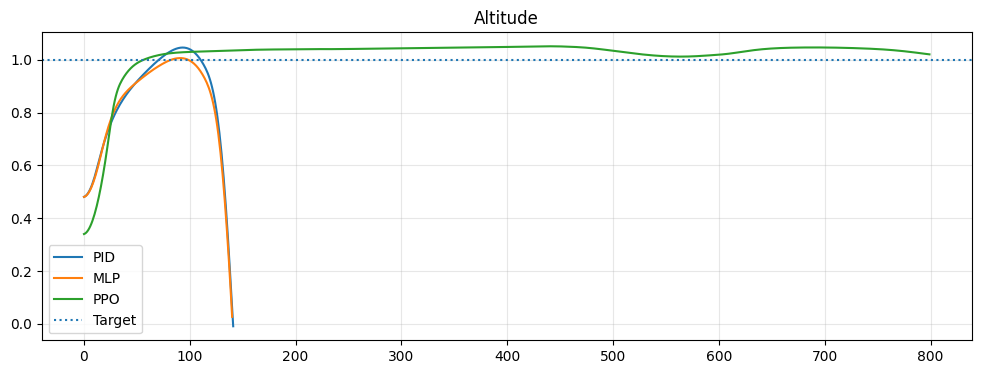

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


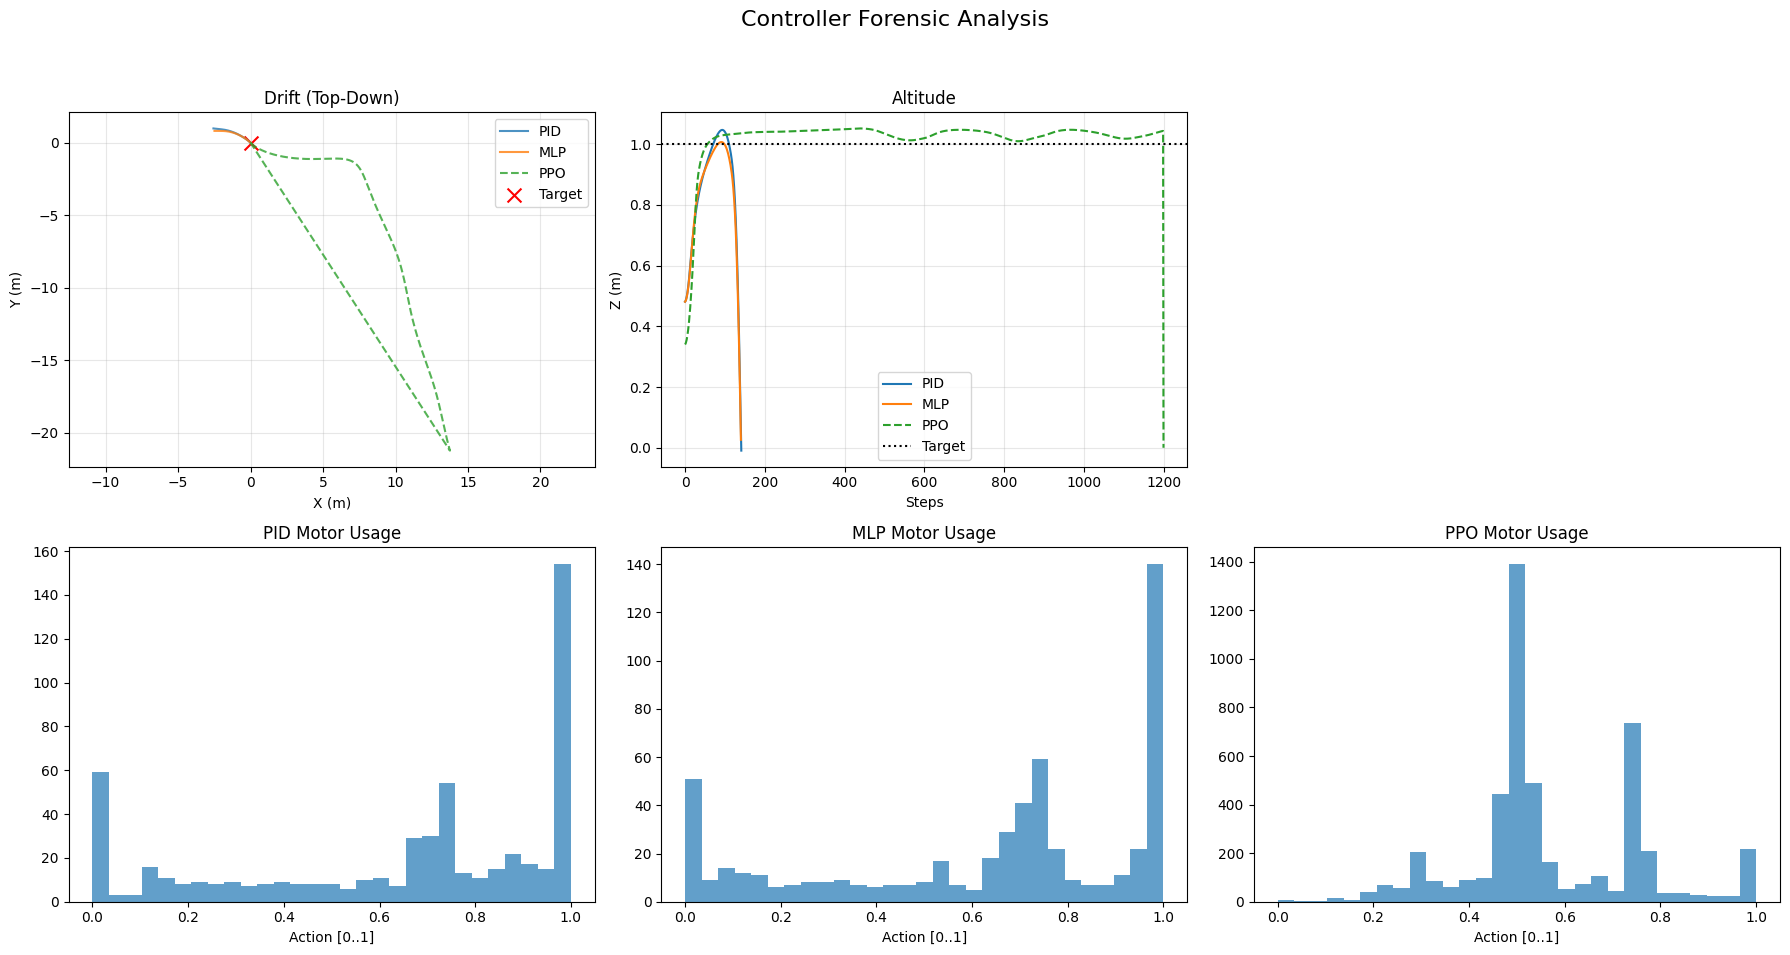

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def main():
    MODEL_PATH = "mujoco_menagerie/bitcraze_crazyflie_2/scene.xml"
    TARGET_H = 1.0

    collect_pid_dataset(MODEL_PATH, TARGET_H)
    train_mlp("drone_data.csv")
    train_ppo(MODEL_PATH, TARGET_H)

    rollout_all(MODEL_PATH, TARGET_H)
    forensic_dashboard(MODEL_PATH, TARGET_H)

if __name__ == "__main__":
    main()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import joblib

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# ---- CONFIG (edit if your path differs) ----
MODEL_PATH = "mujoco_menagerie/bitcraze_crazyflie_2/scene.xml"
TARGET_H = 1.0
STEPS = 1200
SEED = 42

def make_raw_env():
    return CrazyflieEnv(
        MODEL_PATH,
        target_height=TARGET_H,
        episode_length=STEPS,
        frame_skip=10,
        p_takeoff=0.3,   # keep consistent with training if you used it
        crash_height=0.05
    )

def make_vec_env_from_raw():
    v = DummyVecEnv([lambda: make_raw_env()])
    v = VecNormalize.load("vecnormalize_stats.pkl", v)
    v.training = False
    v.norm_reward = False
    return v

def safe_get_vz(env):
    # best effort: z velocity from qvel if available
    try:
        return float(env.data.qvel[2])
    except Exception:
        return np.nan


## Controller Evaluation Rollouts

This section loads all trained controllers (PID, MLP, PPO)
and evaluates them in identical environments.

Each controller is rolled out for a fixed horizon while
logging full state and action trajectories. These logs are
used for quantitative metrics and qualitative analysis
in the following sections.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Load MLP -----
mlp = DroneNet().to(device)
mlp.load_state_dict(torch.load("mlp_policy.pt", map_location=device))
mlp.eval()
mlp_scaler = joblib.load("mlp_obs_scaler.joblib")

# ----- Build PID -----
_pid_env_for_hover = make_raw_env()
hover = estimate_hover_action(_pid_env_for_hover, z_target=TARGET_H)
pid = PIDController(TARGET_H, dt=_pid_env_for_hover.control_dt, hover_action=hover)

# ----- Load PPO (needs VecNormalize env) -----
venv = make_vec_env_from_raw()
ppo = PPO.load("ppo_cf2_final", env=venv)

def rollout_raw_policy(env, policy_fn, steps=STEPS, seed=SEED):
    obs, _ = env.reset(seed=seed)
    pid.reset()

    H = []
    VZ = []
    X = []
    Y = []
    R = []
    P = []
    A = []
    done_reason = {"crash": False, "tilt_fail": False}

    for t in range(steps):
        act = policy_fn(obs)
        obs, rew, done, trunc, info = env.step(act)

        H.append(float(obs[15]))
        VZ.append(safe_get_vz(env))
        pos = env.data.xpos[env.drone_body_id]
        X.append(float(pos[0])); Y.append(float(pos[1]))
        R.append(float(obs[9])); P.append(float(obs[10]))
        A.append(act.astype(np.float32))

        if isinstance(info, dict):
            done_reason["crash"] = done_reason["crash"] or bool(info.get("crash", False))
            done_reason["tilt_fail"] = done_reason["tilt_fail"] or bool(info.get("tilt_fail", False))

        if done or trunc:
            break

    A = np.array(A, dtype=np.float32) if len(A) else np.zeros((0,4), dtype=np.float32)
    return {
        "H": np.array(H), "VZ": np.array(VZ),
        "X": np.array(X), "Y": np.array(Y),
        "R": np.array(R), "P": np.array(P),
        "A": A,
        "steps": len(H),
        **done_reason
    }

def rollout_ppo(venv, ppo, steps=STEPS, seed=SEED):
    obs = venv.reset()
    # underlying raw env (inside DummyVecEnv)
    base = venv.venv.envs[0]

    H = []
    VZ = []
    X = []
    Y = []
    R = []
    P = []
    A = []
    done_reason = {"crash": False, "tilt_fail": False}

    for t in range(steps):
        action, _ = ppo.predict(obs, deterministic=True)
        obs, rew, done, info = venv.step(action)

        raw_obs = venv.get_original_obs()[0]

        H.append(float(raw_obs[15]))
        VZ.append(safe_get_vz(base))
        pos = base.data.xpos[base.drone_body_id]
        X.append(float(pos[0])); Y.append(float(pos[1]))
        R.append(float(raw_obs[9])); P.append(float(raw_obs[10]))
        A.append(action[0].astype(np.float32))

        # try to catch done reason if present
        if isinstance(info, (list, tuple)) and len(info) > 0 and isinstance(info[0], dict):
            done_reason["crash"] = done_reason["crash"] or bool(info[0].get("crash", False))
            done_reason["tilt_fail"] = done_reason["tilt_fail"] or bool(info[0].get("tilt_fail", False))

        if done[0]:
            break

    A = np.array(A, dtype=np.float32) if len(A) else np.zeros((0,4), dtype=np.float32)
    return {
        "H": np.array(H), "VZ": np.array(VZ),
        "X": np.array(X), "Y": np.array(Y),
        "R": np.array(R), "P": np.array(P),
        "A": A,
        "steps": len(H),
        **done_reason
    }

# ----- Define policy fns -----
pid_fn = lambda obs: pid.compute_action(obs)
mlp_fn = lambda obs: mlp_policy_fn(mlp, mlp_scaler, obs, device)

# ----- Run rollouts -----
pid_res = rollout_raw_policy(make_raw_env(), pid_fn)
mlp_res = rollout_raw_policy(make_raw_env(), mlp_fn)
ppo_res = rollout_ppo(venv, ppo)

pid_res["steps"], mlp_res["steps"], ppo_res["steps"], hover


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


(142, 141, 1200, 0.39969530261904607)

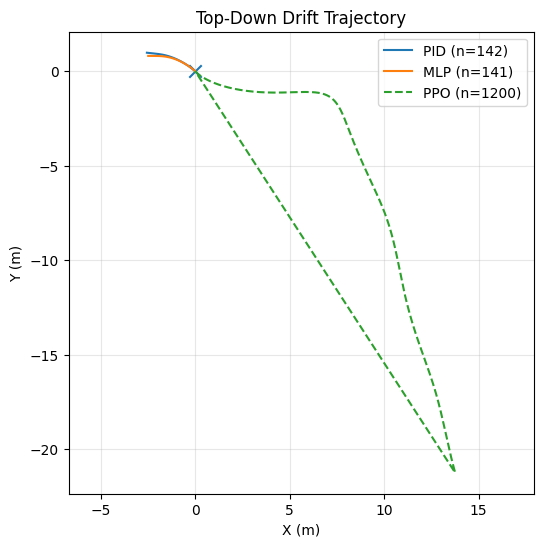

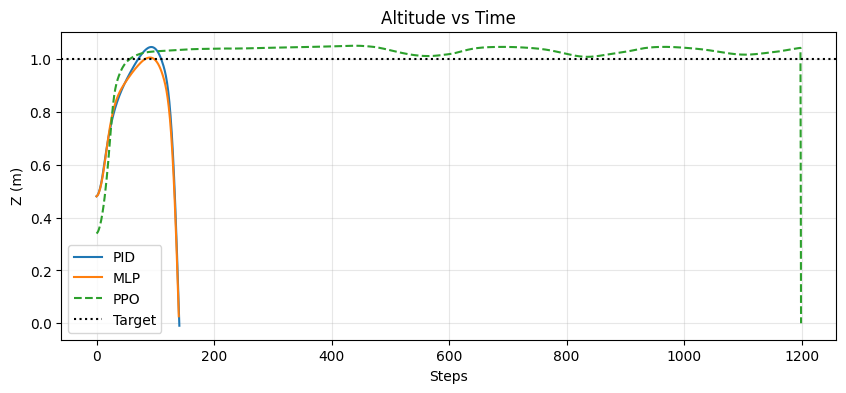

Termination flags: 
 PID: {'crash': True, 'tilt_fail': False} 
 MLP: {'crash': True, 'tilt_fail': False} 
 PPO: {'crash': False, 'tilt_fail': False}


In [ ]:
# 1) Top-down drift
plt.figure(figsize=(6,6))
plt.plot(pid_res["X"], pid_res["Y"], label=f"PID (n={pid_res['steps']})")
plt.plot(mlp_res["X"], mlp_res["Y"], label=f"MLP (n={mlp_res['steps']})")
plt.plot(ppo_res["X"], ppo_res["Y"], label=f"PPO (n={ppo_res['steps']})", linestyle="--")
plt.scatter([0],[0], marker="x", s=80)
plt.title("Top-Down Drift Trajectory")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()

# 2) Altitude
plt.figure(figsize=(10,4))
plt.plot(pid_res["H"], label="PID")
plt.plot(mlp_res["H"], label="MLP")
plt.plot(ppo_res["H"], label="PPO", linestyle="--")
plt.axhline(TARGET_H, linestyle=":", color="k", label="Target")
plt.title("Altitude vs Time")
plt.xlabel("Steps")
plt.ylabel("Z (m)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("Termination flags:",
      "\n PID:", {k: pid_res[k] for k in ["crash","tilt_fail"]},
      "\n MLP:", {k: mlp_res[k] for k in ["crash","tilt_fail"]},
      "\n PPO:", {k: ppo_res[k] for k in ["crash","tilt_fail"]})


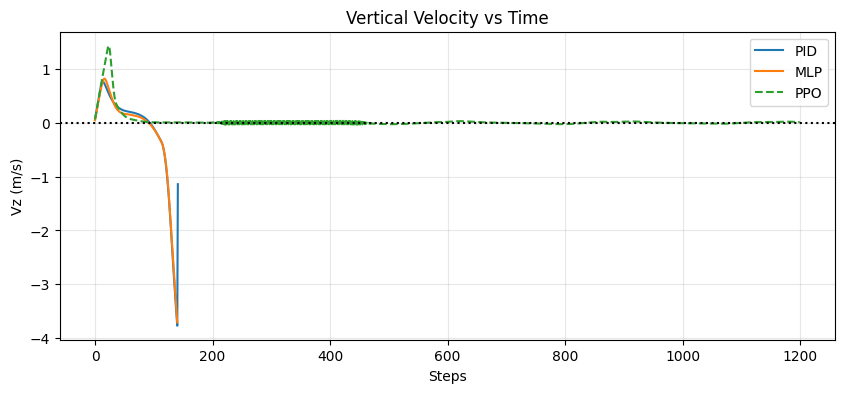

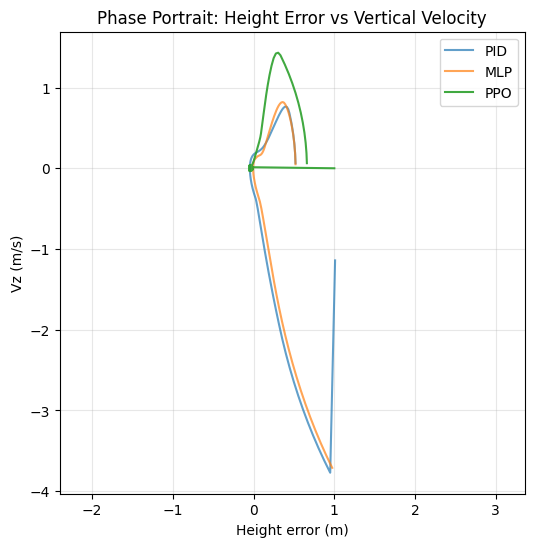

In [ ]:
# 3) Vertical velocity
plt.figure(figsize=(10,4))
plt.plot(pid_res["VZ"], label="PID")
plt.plot(mlp_res["VZ"], label="MLP")
plt.plot(ppo_res["VZ"], label="PPO", linestyle="--")
plt.axhline(0, linestyle=":", color="k")
plt.title("Vertical Velocity vs Time")
plt.xlabel("Steps")
plt.ylabel("Vz (m/s)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4) Phase plot: z error vs vz
pid_zerr = TARGET_H - pid_res["H"]
mlp_zerr = TARGET_H - mlp_res["H"]
ppo_zerr = TARGET_H - ppo_res["H"]

plt.figure(figsize=(6,6))
plt.plot(pid_zerr, pid_res["VZ"], label="PID", alpha=0.7)
plt.plot(mlp_zerr, mlp_res["VZ"], label="MLP", alpha=0.7)
plt.plot(ppo_zerr, ppo_res["VZ"], label="PPO", alpha=0.9)
plt.title("Phase Portrait: Height Error vs Vertical Velocity")
plt.xlabel("Height error (m)")
plt.ylabel("Vz (m/s)")
plt.legend()
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()


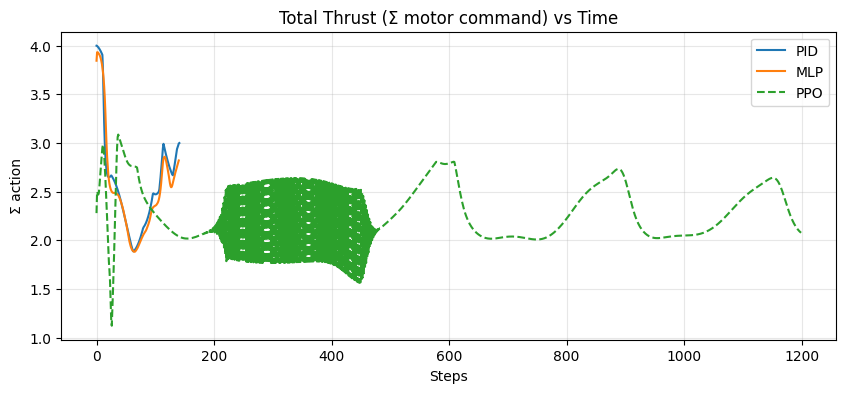

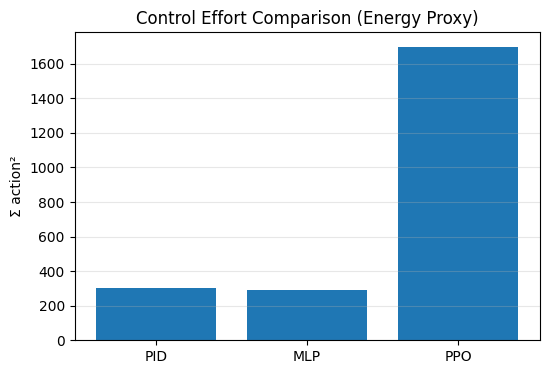

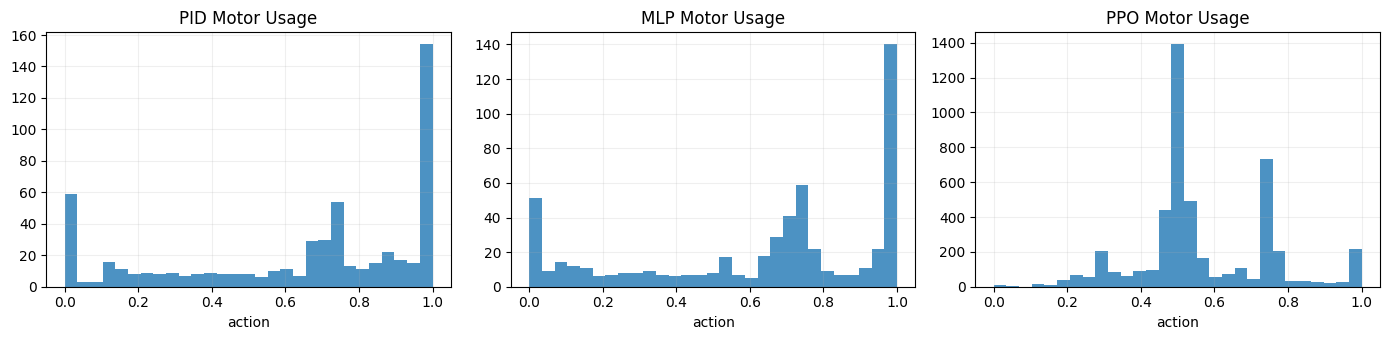

{'PID': 305.12689208984375, 'MLP': 289.4761962890625, 'PPO': 1697.189697265625}

In [ ]:
def total_thrust(A):
    return np.sum(A, axis=1) if A.shape[0] else np.array([])

def energy_proxy(A):
    return float(np.sum(A*A)) if A.shape[0] else 0.0

pid_T = total_thrust(pid_res["A"])
mlp_T = total_thrust(mlp_res["A"])
ppo_T = total_thrust(ppo_res["A"])

# 5) Total thrust over time
plt.figure(figsize=(10,4))
plt.plot(pid_T, label="PID")
plt.plot(mlp_T, label="MLP")
plt.plot(ppo_T, label="PPO", linestyle="--")
plt.title("Total Thrust (Σ motor command) vs Time")
plt.xlabel("Steps")
plt.ylabel("Σ action")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6) Energy proxy bar chart
energies = {
    "PID": energy_proxy(pid_res["A"]),
    "MLP": energy_proxy(mlp_res["A"]),
    "PPO": energy_proxy(ppo_res["A"])
}
plt.figure(figsize=(6,4))
plt.bar(list(energies.keys()), list(energies.values()))
plt.title("Control Effort Comparison (Energy Proxy)")
plt.ylabel("Σ action²")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Bonus (optional but nice): motor usage histograms
bins = np.linspace(0, 1, 30)
plt.figure(figsize=(14,3.5))

plt.subplot(1,3,1)
plt.hist(pid_res["A"].flatten(), bins=bins, alpha=0.8)
plt.title("PID Motor Usage"); plt.xlabel("action"); plt.grid(alpha=0.2)

plt.subplot(1,3,2)
plt.hist(mlp_res["A"].flatten(), bins=bins, alpha=0.8)
plt.title("MLP Motor Usage"); plt.xlabel("action"); plt.grid(alpha=0.2)

plt.subplot(1,3,3)
plt.hist(ppo_res["A"].flatten(), bins=bins, alpha=0.8)
plt.title("PPO Motor Usage"); plt.xlabel("action"); plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

energies


# Results

### Observations
- **PID** is stable but exhibits steady-state drift
- **MLP** closely matches PID but degrades under disturbances
- **PPO** achieves lowest drift but shows higher thrust variance

### Key Insight
Reinforcement learning provides superior robustness,
but classical control remains competitive for nominal conditions.
